<a href="https://colab.research.google.com/github/bforoura/GENAI26/blob/main/Module3/Document_Processing_Chunking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Document Processing and Chunking Startegies in RAG Systems**

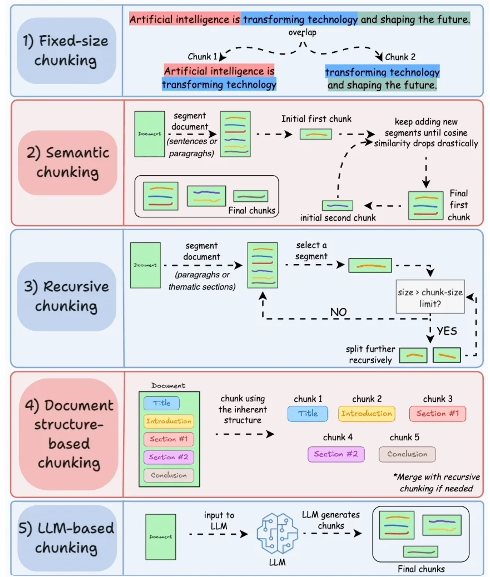

In [2]:
# Install the Google-specific LangChain packages and PDF tools
!pip install -qU langchain-google-genai langchain-community pypdf langchain-experimental jq



# **The Setup**

In [5]:
import os
import requests
from google.colab import userdata
from langchain_community.document_loaders import PyPDFLoader, WebBaseLoader, JSONLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter, CharacterTextSplitter
from langchain_experimental.text_splitter import SemanticChunker
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# Set up API Key from Colab Secrets
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')


# **Document Loading (Extraction)**

In [6]:
# Loading from a URL (PDF)
pdf_url = "https://bitcoin.org/bitcoin.pdf"
pdf_loader = PyPDFLoader(pdf_url)
pdf_docs = pdf_loader.load()
print(f"PDF Loaded: {len(pdf_docs)} pages")



# Loading from a Website (HTML)
web_loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
web_docs = web_loader.load()
print(f"Web Content Loaded: {len(web_docs)} document(s)")



# Loading Metadata (JSON)
# First, let's create a dummy JSON file for the example
import json
data = [{"content": "RAG is a technique to grant LLMs long-term memory."},
        {"content": "Ollama allows running LLMs locally."}]
with open('data.json', 'w') as f:
    json.dump(data, f)



# jq_schema=".[].content" means "get the content field from every object in the array"
json_loader = JSONLoader(file_path='data.json', jq_schema=".[].content", text_content=True)
json_docs = json_loader.load()
print(f"JSON Loaded: {len(json_docs)} entries")



PDF Loaded: 9 pages
Web Content Loaded: 1 document(s)
JSON Loaded: 2 entries


# **Fixed-Size Chunking (The Basic Way)**

* Splitting text by character count.
* Simple, but often breaks sentences mid-thought

* **overlap** is the text that is copied from the end of one chunk to the beginning of the next. It acts as a **context bridge** between these pieces.

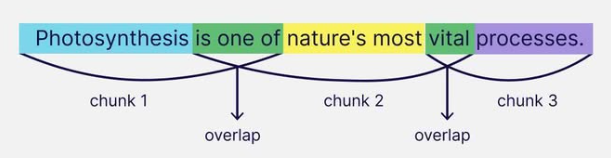

In [7]:
# We'll use the Web content for this example
text_content = web_docs[0].page_content


# This splitter only looks for spaces
basic_splitter = CharacterTextSplitter(
    separator=" ",
    chunk_size=1000,
    chunk_overlap=100
)

basic_chunks = basic_splitter.split_text(text_content)
print(f"Fixed-Size Chunks created: {len(basic_chunks)}")

Fixed-Size Chunks created: 49


# **Recursive Character Chunking (The Recommended Way)**

* The **recursive** version is like an editor: it tries to find the most **natural** place to cut so the AI doesn't receive a fragment of a sentence that makes no sense.

* It tries to split at logical points in a **specific order (1-5)**:

   1. **"\n\n" (Paragraphs)**: It first tries to keep paragraphs together.
   2. **"\n" (Lines)**:       If a paragraph is too big, it looks for line breaks.
   3. **". " (Sentences)**:  If a line is too big, it tries to split at the end of a sentence.
   4.  **" " (Words)**:       If a sentence is too long, it splits at a space.
   5. **"" (Characters)**:   As a last resort, it will split mid-word to meet the size requirement.

* We should use different separators based on the task we have. For example, if splitting **Python code**, the standard **period** or **space** logic might break a function or a loop in a weird spot. In that case, we migh want a list that is more like this:

  `separators=["class ", "def ", "\n\n", "\n", " ", ""]`



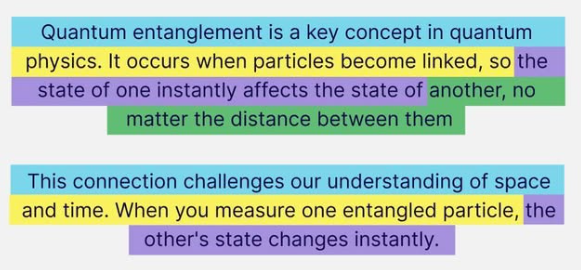

In [8]:
# This splitter looks at the text and tries to split it in order

recursive_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=150,
    length_function=len
)

recursive_chunks = recursive_splitter.split_documents(pdf_docs)
print(f"Recursive Chunks created from PDF: {len(recursive_chunks)}")
print(f"Example Content (Chunk 1): \n{recursive_chunks[0].page_content[:300]}...")



Recursive Chunks created from PDF: 28
Example Content (Chunk 1): 
Bitcoin: A Peer-to-Peer Electronic Cash System
Satoshi Nakamoto
satoshin@gmx.com
www.bitcoin.org
Abstract.  A purely peer-to-peer version of  electronic cash would allow online  
payments to be sent directly from one party to another without going through a  
financial institution.  Digital signatur...


# **Semantic Chunking (The AI-Powered Way)**

* This uses **Gemini Embeddings** to detect **topic shifts** and split there

* It might seem counterintuitive that a **smart semantic** method isn't always the preferred method of chunking, but **Recursive Character Text Splitting** is considered the **old reliable method** for several practical reasons:
   1. **Semantic chunking is computationally expensive.** To find a cut, we must send every single sentence to an **embedding model**, wait for the vector response, and then calculate the math between them. This costs money and time. However, the **Recursive method is fast and cheap** since it can be done on a CPU.
   >
   2. **Semantic chunking** follows the **meaning** of the text. If a document discusses one **topic for 20 pages without a massive shift in meaning**, a semantic chunker might create a massive, 5,000-word chunk that overflows the model's memory.
   >
   3. Recursive splitting is **hierarchical.** It doesn't just cut blindly; it tries to respect the **document's natural structure** using a list of separators. This keeps related ideas together remarkably well without needing a complex AI model to **understand** the text.

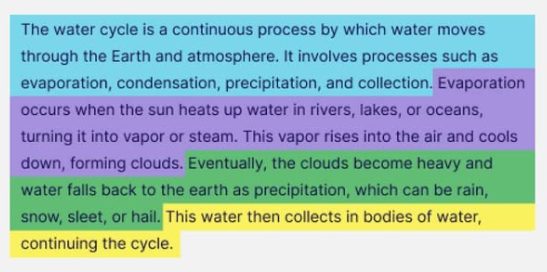

In [10]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_experimental.text_splitter import SemanticChunker
import time

# 1. Setup Embeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

# 2. Optimization: Use a larger buffer to group sentences (saves API calls)
semantic_splitter = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile",
    buffer_size=5
)

# 3. Batch Processing Function
def process_in_batches(text, chunk_size=3000):
    # Split the massive text into smaller 'chapters' to avoid flooding the API
    text_batches = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
    all_semantic_chunks = []

    print(f"Total batches to process: {len(text_batches)}")

    for i, batch in enumerate(text_batches):
        print(f"Processing Batch {i+1}/{len(text_batches)}...")
        try:
            # Get chunks for this specific batch
            batch_chunks = semantic_splitter.split_text(batch)
            all_semantic_chunks.extend(batch_chunks)

            # MANDATORY: Wait 15 seconds to allow the RPM quota to refill
            if i < len(text_batches) - 1:
                print("Refilling API quota... waiting 15 seconds.")
                time.sleep(15)

        except Exception as e:
            if "429" in str(e):
                print("Limit hit! Cooling down for 60 seconds...")
                time.sleep(60) # Extended cooldown
                # Retry once
                batch_chunks = semantic_splitter.split_text(batch)
                all_semantic_chunks.extend(batch_chunks)
            else:
                raise e

    return all_semantic_chunks

# 4. Execute
try:
    print(" Starting Semantic Chunking...")
    semantic_chunks = process_in_batches(text_content)
    print(f"Success! Created {len(semantic_chunks)} total semantic chunks.")
except Exception as e:
    print(f" Critical Failure: {e}")



 Starting Semantic Chunking...
Total batches to process: 15
Processing Batch 1/15...
Refilling API quota... waiting 15 seconds.
Processing Batch 2/15...
Refilling API quota... waiting 15 seconds.
Processing Batch 3/15...
Refilling API quota... waiting 15 seconds.
Processing Batch 4/15...
Refilling API quota... waiting 15 seconds.
Processing Batch 5/15...
Limit hit! Cooling down for 60 seconds...
Processing Batch 6/15...
Refilling API quota... waiting 15 seconds.
Processing Batch 7/15...
Refilling API quota... waiting 15 seconds.
Processing Batch 8/15...
Refilling API quota... waiting 15 seconds.
Processing Batch 9/15...
Refilling API quota... waiting 15 seconds.
Processing Batch 10/15...
Limit hit! Cooling down for 60 seconds...
Processing Batch 11/15...
Refilling API quota... waiting 15 seconds.
Processing Batch 12/15...
Refilling API quota... waiting 15 seconds.
Processing Batch 13/15...
Refilling API quota... waiting 15 seconds.
Processing Batch 14/15...
Refilling API quota... waiti

# **Examining the Chunks**

In [11]:
# Function to preview the first 2 chunks of each method
def preview_chunks(name, chunks, num_to_show=2):
    print(f"\n{'='*20} {name.upper()} PREVIEW {'='*20}")
    for i, chunk in enumerate(chunks[:num_to_show]):
        # If it's a string (from split_text) or a Document object
        content = chunk.page_content if hasattr(chunk, 'page_content') else chunk

        print(f"\n--- CHUNK {i+1} ({len(content)} characters) ---")
        print(content[:400] + "...") # Show first 400 chars
    print(f"\n{'='*50}")



# Display previews
preview_chunks("Basic (Fixed)", basic_chunks)
preview_chunks("Recursive", recursive_chunks)
preview_chunks("Semantic", semantic_chunks)




==================== BASIC (FIXED) PREVIEW ====================

--- CHUNK 1 (994 characters) ---
LLM Powered Autonomous Agents | Lil'Log







































Lil'Log

















|






Posts




Archive




Search




Tags




FAQ









 LLM Powered Autonomous Agents
 
Date: June 23, 2023 | Estimated Reading Time: 31 min | Author: Lilian Weng


 


Table of Contents



Agent System Overview

Component One: Planning

Task Decomposition

Self-Reflection


Component Tw...

--- CHUNK 2 (998 characters) ---
stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refine...


==================== RECURSIVE PREVIEW ==================

# **Analyzing the Chunks**


1. **Basic (Fixed)**
   * **Chunk 1** is 935 characters and **Chunk 2** is 998 characters.
   * Look at the start of Chunk 2: s**tories, essays and programs....**
   * The first half of that sentence is trapped at the end of Chunk 1.
   * If you asked the AI about "**programs**," it might lose the context that they are "stories and essays."
   * It's a messy, mid-sentence split.
   * This is the **dumb split**.

2. **Recursive**:
   * **Chunk 1** is 935 characters and **Chunk 2** is 928 characters.

   * It didn't wait until 1000 characters. It saw that the **Abstract** ended at 935 characters and decided that was a perfect place to stop.

   * It keeps the **Abstract** and the **Introduction** as distinct, clean units.
   * This method is not too smart, not too dumb.

3. **Semantic**:
   * **Chunk 1** is a massive 4781 characters, while **Chunk 2** is tiny  with only 16 characters.

   * This is the most interesting result. The AI read the first 4,700 characters and decided, **the title, the table of contents, and the intro** is one single topic. It refused to break them apart because they are semantically related.

   * **Chunk 2** is just the word **Observation: .......**
   *  The AI detected a massive **topic shift** here.
   * It decided that everything before **Observation** was one idea, and  **observation** was the start of a brand new, different concept.

   * This usually happens when the source text has a header or a transition phrase that is mathematically very different from the text before it.

   * The Semantic Chunker says: **I don't care that this chunk is small; it's a new topic, so it deserves its own space.**


 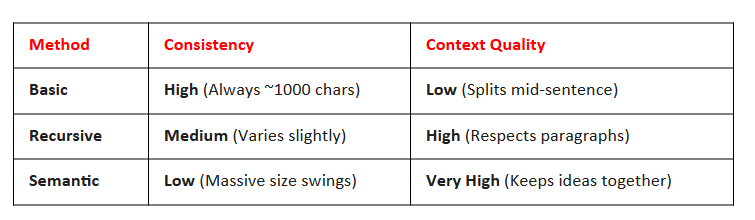



# **Summary of Chunking Performance**

In [16]:
import pandas as pd

# Helper function to get length of a specific chunk index
def get_len_at(chunks, index):
    if len(chunks) > index:
        c = chunks[index]
        return len(c.page_content if hasattr(c, 'page_content') else c)
    return 0

# Helper function to calculate average length across all chunks
def get_avg_len(chunks):
    if not chunks: return 0
    lengths = [len(c.page_content if hasattr(c, 'page_content') else c) for c in chunks]
    return round(sum(lengths) / len(lengths), 2)

data = {
    "Strategy": ["Basic (Fixed)", "Recursive", "Semantic"],
    "Total Chunks": [len(basic_chunks), len(recursive_chunks), len(semantic_chunks)],
    "Chunk 1 Len": [get_len_at(basic_chunks, 0), get_len_at(recursive_chunks, 0), get_len_at(semantic_chunks, 0)],
    "Chunk 2 Len": [get_len_at(basic_chunks, 1), get_len_at(recursive_chunks, 1), get_len_at(semantic_chunks, 1)],
    "Avg Length": [get_avg_len(basic_chunks), get_avg_len(recursive_chunks), get_avg_len(semantic_chunks)],
    "Logic": ["Fixed char count", "Paragraph/Sentence structure", "AI Topic Detection"]
}

df = pd.DataFrame(data)
print(df)


        Strategy  Total Chunks  Chunk 1 Len  Chunk 2 Len  Avg Length  \
0  Basic (Fixed)            49          994          998      983.49   
1      Recursive            28          935          928      850.25   
2       Semantic            44         2430          559      993.02   

                          Logic  
0              Fixed char count  
1  Paragraph/Sentence structure  
2            AI Topic Detection  


# **Other Chunking Methods**

* **Document-Based Chunking**

  * This technique creates chunks based on the natural divisions within the document, such as headings or sections.
  
  * It's very effective for structured data **like HTML, Markdown, or code files** but it's less useful when the data lacks clear structural elements.

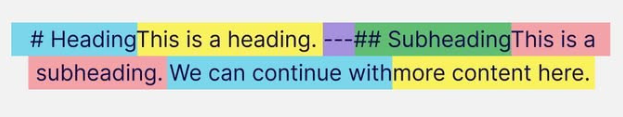


* **LLM-Based Chunking**

   * This advanced technique uses a Language Model (LLM) to generate chunks.

   * Instead of following code rules or character counts, we ask an LLM to read the text and decide where the logical breaks are.
   
   * The LLM processes the text and generates semantically isolated sentences or propositions that can stand alone.

   * While this method is highly accurate, it is also the **most computationally demanding**.
  
   * It is currently the **top-tier strategy**.

 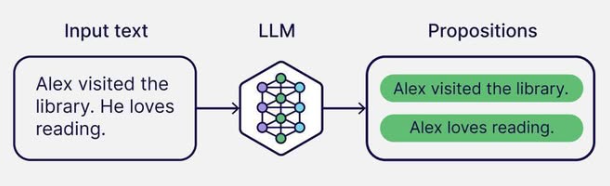
